In [205]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import prepare as prep

import warnings
warnings.filterwarnings('ignore')

from scipy import stats

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

In [206]:
df = pd.read_csv('wine_df.csv')

In [207]:
df.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'sulphates'], inplace=True)

In [208]:
df.rename(columns={'fixed acidity':'fixed','volatile acidity':'volatile','citric acid':'citric',
           'residual sugar':'sugar','free sulfur dioxide':'fso2','total sulfur dioxide':'tso2'}, inplace=True)

In [209]:
df, var_fences = prep.remove_outliers(df)

quality column ignored
type column ignored


In [210]:
df = df[(df['quality']!=3) & (df['quality']!=9)]

In [211]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5089 entries, 1 to 6496
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   fixed      5089 non-null   float64
 1   volatile   5089 non-null   float64
 2   citric     5089 non-null   float64
 3   sugar      5089 non-null   float64
 4   chlorides  5089 non-null   float64
 5   fso2       5089 non-null   float64
 6   tso2       5089 non-null   float64
 7   density    5089 non-null   float64
 8   pH         5089 non-null   float64
 9   alcohol    5089 non-null   float64
 10  quality    5089 non-null   int64  
 11  type       5089 non-null   object 
dtypes: float64(10), int64(1), object(1)
memory usage: 516.9+ KB


In [212]:
df['alcohol'].min()

8.4

In [213]:
cont = df.select_dtypes(include=['float64','int64'])
cat = df.select_dtypes(include='object')

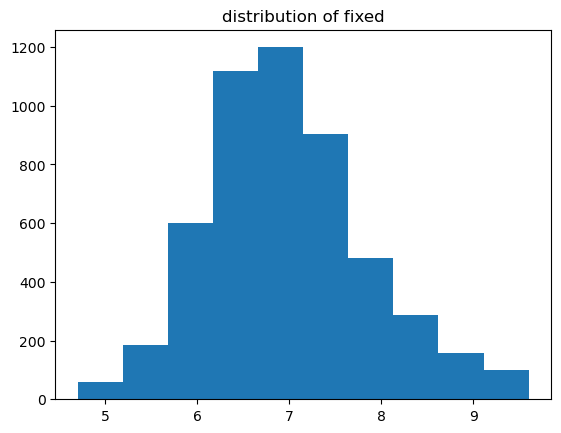

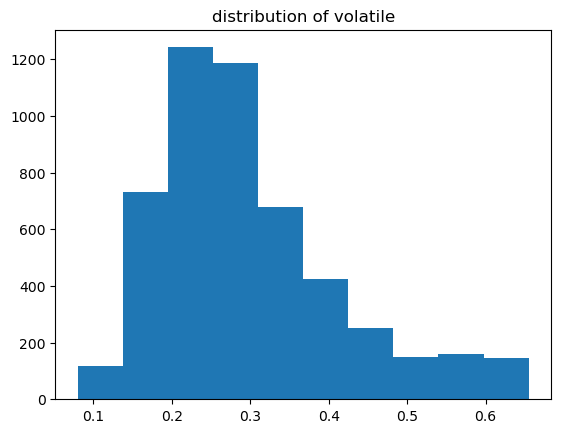

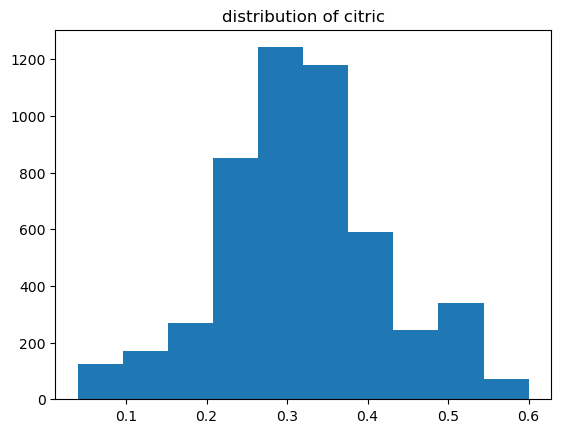

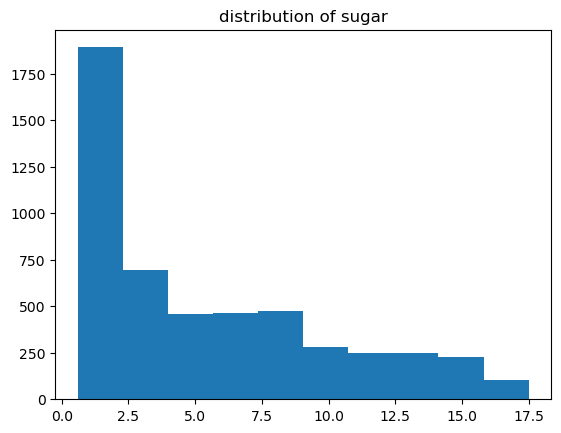

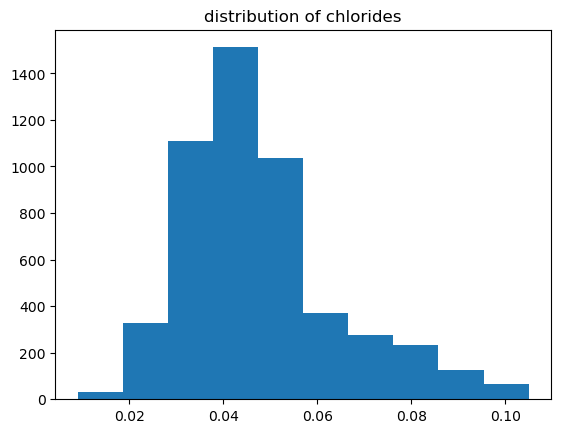

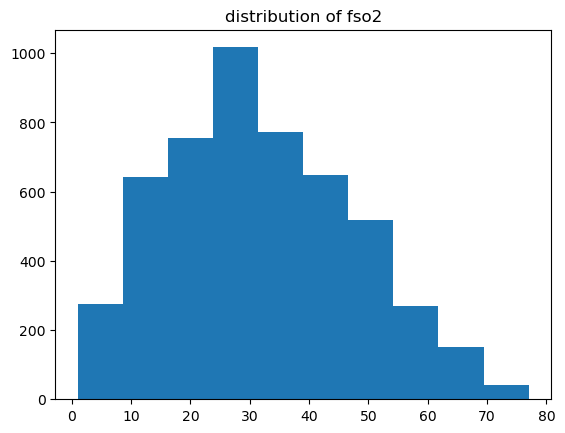

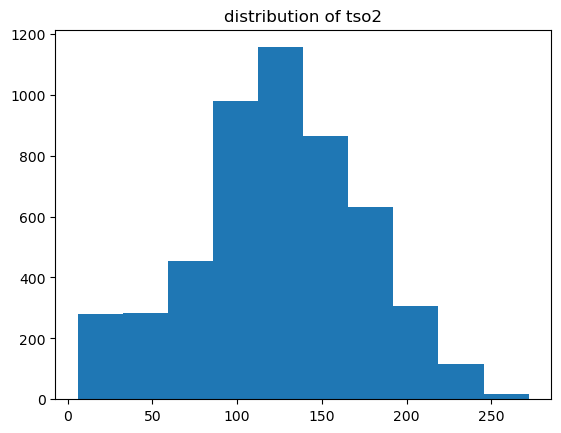

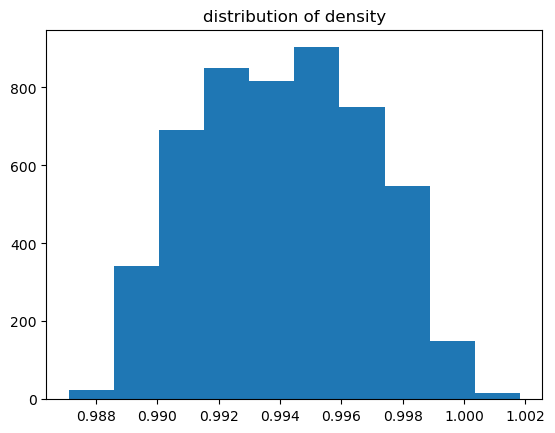

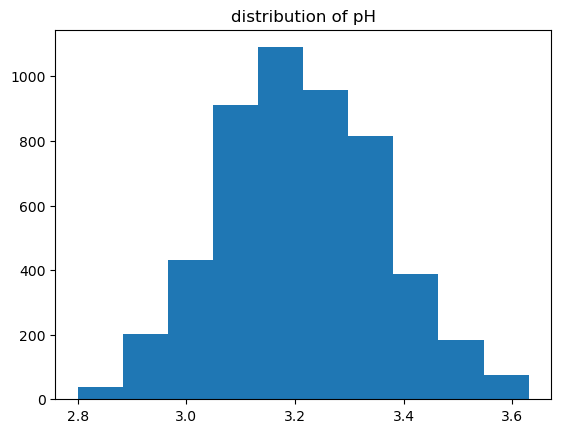

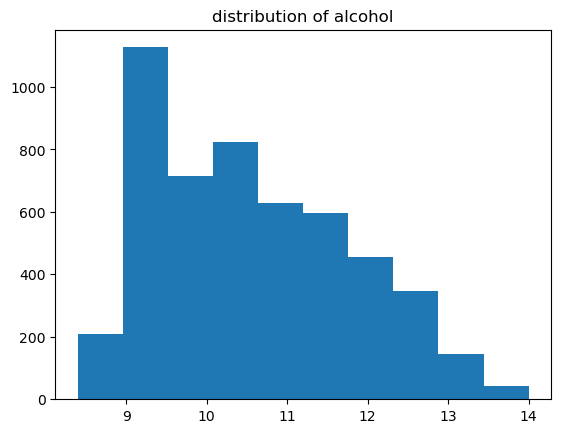

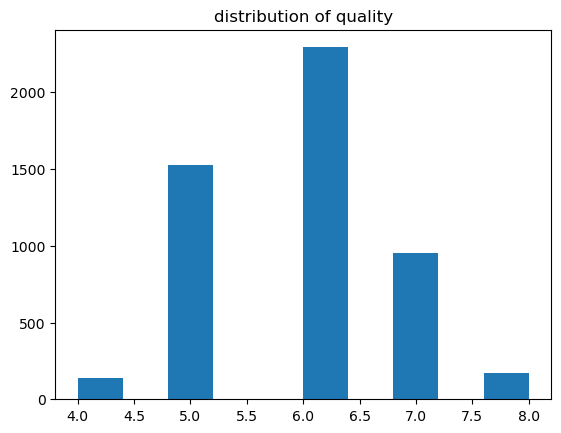

In [214]:
for col in cont:
    
    plt.hist(df[col])
    plt.title(f'distribution of {col}')
    plt.show()

In [215]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5089 entries, 1 to 6496
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   fixed      5089 non-null   float64
 1   volatile   5089 non-null   float64
 2   citric     5089 non-null   float64
 3   sugar      5089 non-null   float64
 4   chlorides  5089 non-null   float64
 5   fso2       5089 non-null   float64
 6   tso2       5089 non-null   float64
 7   density    5089 non-null   float64
 8   pH         5089 non-null   float64
 9   alcohol    5089 non-null   float64
 10  quality    5089 non-null   int64  
 11  type       5089 non-null   object 
dtypes: float64(10), int64(1), object(1)
memory usage: 516.9+ KB


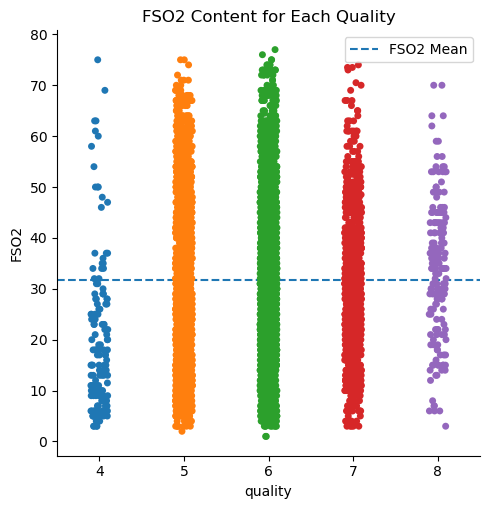

In [216]:
sns.catplot(x='quality', y='fso2', data=df)
plt.axhline(df['fso2'].mean(), linestyle='--', label='FSO2 Mean')
plt.ylabel('FSO2')
plt.title('FSO2 Content for Each Quality')
plt.legend()
plt.show()

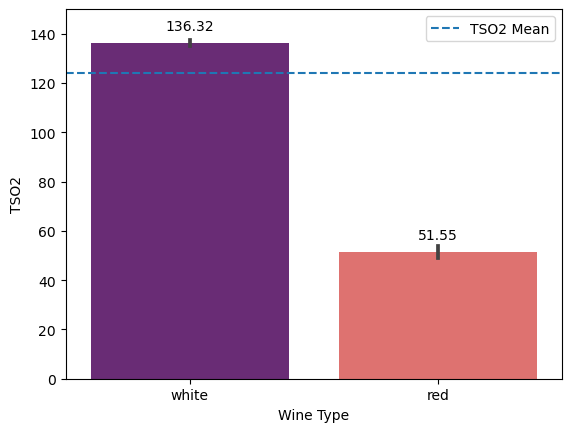

In [217]:
fig, ax = plt.subplots()
bplot = sns.barplot(x='type', y='tso2', data=df, palette='magma')
plt.axhline(df['tso2'].mean(), linestyle='--', label='TSO2 Mean')
plt.xlabel('Wine Type')
plt.ylabel('TSO2')
ax.bar_label(bplot.containers[0], padding=7, fmt='%.2f')
plt.ylim(0,150)
plt.legend()
plt.show()

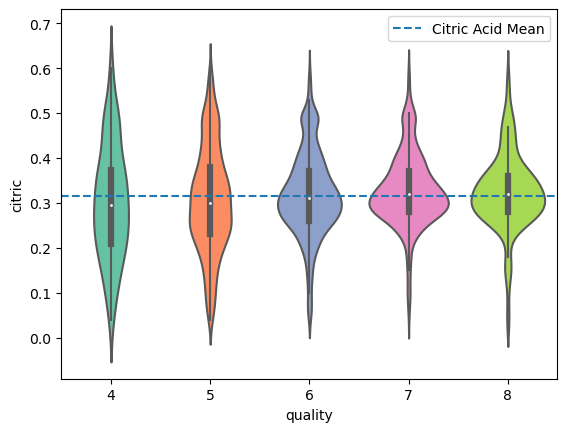

In [218]:
sns.violinplot(x='quality', y='citric', data=df, palette='Set2', saturation=1)
plt.axhline(df['citric'].mean(), linestyle='--', label='Citric Acid Mean')
plt.legend()

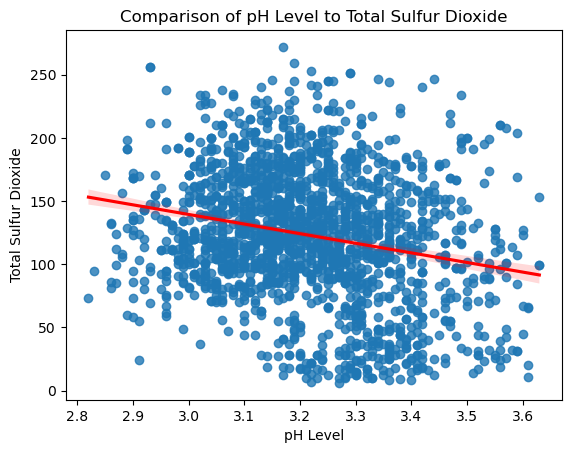

In [219]:
sns.regplot(x='pH', y='tso2', data=df.sample(2000), line_kws={'color':'red'})
plt.title('Comparison of pH Level to Total Sulfur Dioxide')
plt.ylabel('Total Sulfur Dioxide')
plt.xlabel('pH Level')
plt.show()

In [220]:
fso2_6 = df[df['quality']>=6]['fso2']
fso2_mean = df['fso2'].mean()

In [221]:
t, p = stats.ttest_1samp(fso2_6, fso2_mean)

In [222]:
a = .05

In [223]:
p/2<a
t>0

True

In [224]:
p

0.030982233765454645

In [225]:
red = df[df['type']=='red']['tso2']
tso2_mean = df['tso2'].mean()

In [226]:
t, p = stats.ttest_1samp(red, tso2_mean)

In [227]:
p/2<a
t<0

True

In [228]:
citric_6 = df[df['quality']>=6]['citric']
citric = df['citric'].mean()

In [229]:
t, p = stats.ttest_1samp(citric_6, citric)

In [230]:
p/2<a

True

In [231]:
t>0

True

In [232]:
corr, p = stats.pearsonr(df['tso2'], df['pH'])

In [233]:
p<a

True

In [234]:
corr

-0.19802302991311022

In [235]:
col_list = df.select_dtypes(include=['float64','int64']).columns[:-1]

In [236]:
X_train, y_train, X_val, y_val, X_test, y_test = prep.x_y_split(df, 'quality')

In [237]:
X_train, X_val, X_test = prep.mm_scaler(X_train, X_val, X_test, col_list)

In [238]:
X_train.drop(columns=['type'], inplace=True)

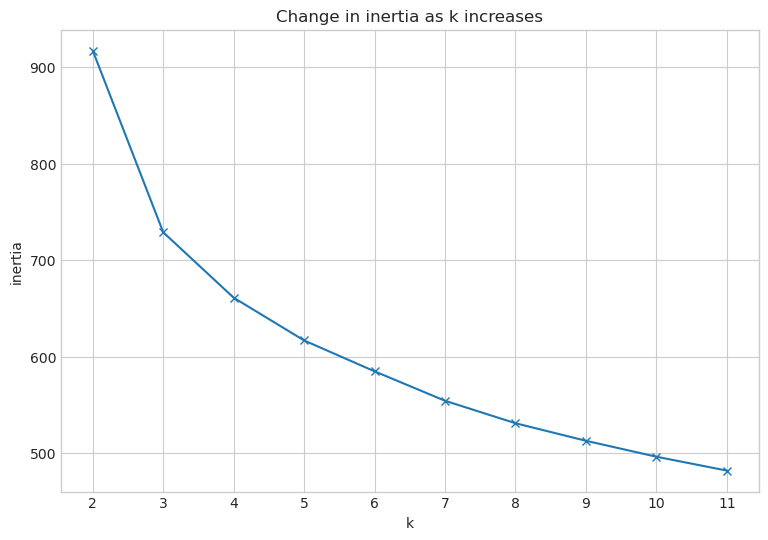

In [239]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X_train).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

In [240]:
kmeans = KMeans(n_clusters=4)

In [241]:
kmeans.fit(X_train)
kmeans.predict(X_train)
X_train['cluster'] = kmeans.predict(X_train)

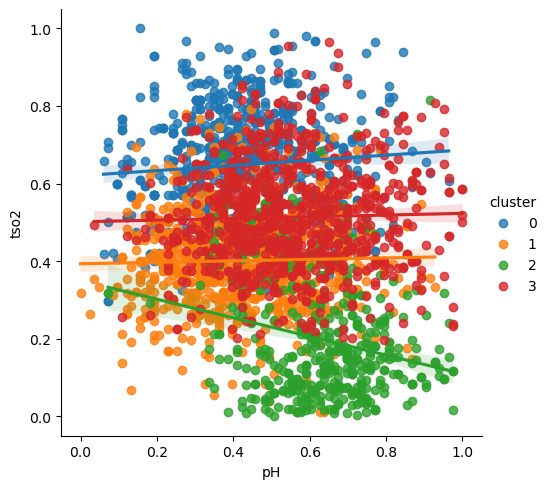

In [242]:
sns.lmplot(x='pH',y='tso2',data=X_train, hue='cluster')
plt.show()

In [243]:
def find_k(X_train, cluster_vars, k_range):
    sse = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k)

        # X[0] is our X_train dataframe..the first dataframe in the list of dataframes stored in X. 
        kmeans.fit(X_train[cluster_vars])

        # inertia: Sum of squared distances of samples to their closest cluster center.
        sse.append(kmeans.inertia_) 

    # compute the difference from one k to the next
    delta = [round(sse[i] - sse[i+1],0) for i in range(len(sse)-1)]

    # compute the percent difference from one k to the next
    pct_delta = [round(((sse[i] - sse[i+1])/sse[i])*100, 1) for i in range(len(sse)-1)]

    # create a dataframe with all of our metrics to compare them across values of k: SSE, delta, pct_delta
    k_comparisons_df = pd.DataFrame(dict(k=k_range[0:-1], 
                             sse=sse[0:-1], 
                             delta=delta, 
                             pct_delta=pct_delta))

    # plot k with inertia
    plt.plot(k_comparisons_df.k, k_comparisons_df.sse, 'bx-')
    plt.xlabel('k')
    plt.ylabel('SSE')
    plt.title('The Elbow Method to find the optimal k\nFor which k values do we see large decreases in SSE?')
    plt.show()

    # plot k with pct_delta
    plt.plot(k_comparisons_df.k, k_comparisons_df.pct_delta, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Percent Change')
    plt.title('For which k values are we seeing increased changes (%) in SSE?')
    plt.show()

    # plot k with delta
    plt.plot(k_comparisons_df.k, k_comparisons_df.delta, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Absolute Change in SSE')
    plt.title('For which k values are we seeing increased changes (absolute) in SSE?')
    plt.show()

    return k_comparisons_df


In [244]:
X = [X_train, X_val, X_test]

In [245]:
X[0]

,fixed,volatile,citric,sugar,chlorides,fso2,tso2,density,pH,alcohol,cluster
3498,0.346939,0.382609,0.571429,0.082840,0.447917,0.226667,0.538153,0.385195,0.698795,0.375000,3
2089,0.653061,0.156522,0.500000,0.059172,0.458333,0.613333,0.574297,0.527073,0.590361,0.214286,3
4934,0.632653,0.904348,0.178571,0.106509,0.802083,0.026667,0.032129,0.712132,0.746988,0.428571,2
446,0.224490,0.347826,0.410714,0.118343,0.468750,0.386667,0.598394,0.294037,0.879518,0.714286,3
3392,0.408163,0.521739,0.392857,0.529586,0.281250,0.453333,0.337349,0.328307,0.216867,0.714286,1
...,...,...,...,...,...,...,...,...,...,...,...
5055,0.489796,0.608696,0.678571,0.289941,0.645833,0.360000,0.485944,0.698424,0.746988,0.375000,2
545,0.346939,0.139130,0.321429,0.047337,0.322917,0.533333,0.570281,0.424263,0.831325,0.285714,3
3501,0.408163,0.278261,0.571429,0.461538,0.343750,0.546667,0.465863,0.522276,0.650602,0.446429,3
4263,0.469388,0.817391,0.017857,0.437870,0.281250,0.240000,0.630522,0.382454,0.554217,0.678571,1


In [246]:
# list of variables I will cluster on. 
cluster_vars = ['fso2', 'tso2']
cluster_name = 'sulfur_dioxide'
k_range = range(2,20)


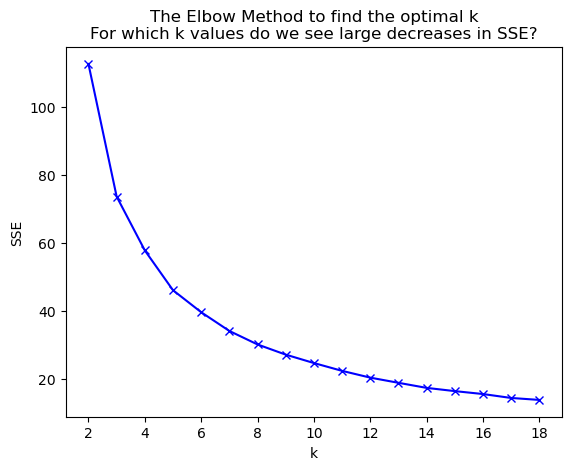

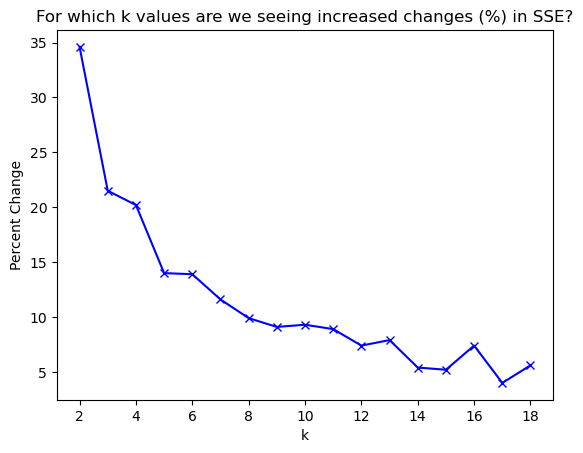

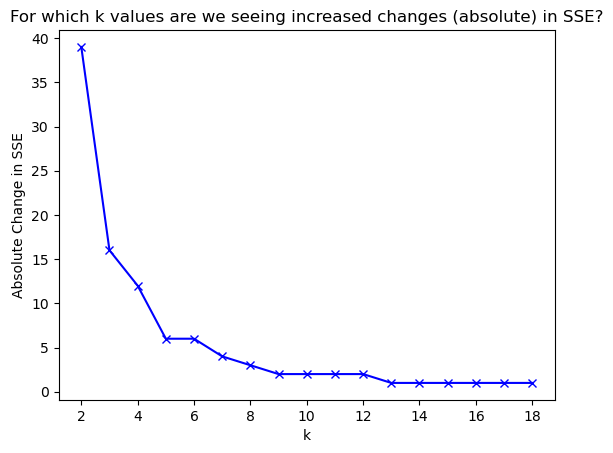

,k,sse,delta,pct_delta
0,2,112.697016,39.0,34.6
1,3,73.702660,16.0,21.5
2,4,57.857422,12.0,20.2
3,5,46.149497,6.0,14.0
4,6,39.677802,6.0,13.9
5,7,34.165450,4.0,11.6
6,8,30.194453,3.0,9.9
7,9,27.204060,2.0,9.1
8,10,24.730623,2.0,9.3
9,11,22.429235,2.0,8.9


In [247]:
find_k(X[0], cluster_vars, k_range)

In [248]:
k = 5

In [249]:
def create_clusters(X_train, k, cluster_vars):
    # create kmean object
    kmeans = KMeans(n_clusters=k, random_state = 42)

    # fit to train and assign cluster ids to observations
    kmeans.fit(X_train[cluster_vars])

    return kmeans


In [250]:
kmeans = create_clusters(X_train, k, cluster_vars)

In [251]:
# get the centroids for each distinct cluster...

def get_centroids(kmeans, cluster_vars, cluster_name):
    # get the centroids for each distinct cluster...

    centroid_col_names = ['centroid_' + i for i in cluster_vars]

    centroid_df = pd.DataFrame(kmeans.cluster_centers_, 
                               columns=centroid_col_names).reset_index().rename(columns={'index': cluster_name})

    return centroid_df


In [252]:
centroid_df_so2 = get_centroids(kmeans, cluster_vars, cluster_name)

In [253]:
# label cluster for each observation in X_train (X[0] in our X list of dataframes), 
# X_validate (X[1]), & X_test (X[2])

def assign_clusters(kmeans, cluster_vars, cluster_name, centroid_df):
    for i in range(len(X)):
        clusters = pd.DataFrame(kmeans.predict(X[i][cluster_vars]), 
                            columns=[cluster_name], index=X[i].index)

        clusters_centroids = clusters.merge(centroid_df, on=cluster_name, copy=False).set_index(clusters.index.values)

        X[i] = pd.concat([X[i], clusters_centroids], axis=1)
    return X


In [255]:
X = assign_clusters(kmeans, cluster_vars, cluster_name, centroid_df_so2)

In [256]:
X[2]

,fixed,volatile,citric,sugar,chlorides,fso2,tso2,density,pH,alcohol,type,sulfur_dioxide,centroid_fso2,centroid_tso2
6072,0.591837,0.486957,0.482143,0.065089,0.729167,0.333333,0.232932,0.688828,0.795181,0.196429,red,4,0.165923,0.146810
132,0.367347,0.600000,0.642857,0.739645,0.302083,0.773333,0.939759,0.739548,0.518072,0.107143,white,4,0.165923,0.146810
1650,0.591837,0.400000,0.803571,0.198225,0.364583,0.346667,0.497992,0.280329,0.337349,0.785714,white,4,0.165923,0.146810
2121,0.612245,0.539130,0.428571,0.254438,0.270833,0.466667,0.409639,0.321453,0.469880,0.678571,white,4,0.165923,0.146810
4081,0.204082,0.295652,0.392857,0.704142,0.416667,0.686667,0.397590,0.671693,0.337349,0.178571,white,4,0.165923,0.146810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2468,0.102041,0.139130,0.535714,0.011834,0.208333,0.333333,0.281124,0.304318,0.542169,0.303571,white,3,0.427301,0.663152
1718,0.938776,0.208696,0.517857,0.065089,0.427083,0.360000,0.686747,0.568197,0.433735,0.107143,white,3,0.427301,0.663152
4790,0.306122,0.382609,0.678571,0.094675,0.281250,0.360000,0.485944,0.204935,0.397590,0.571429,white,3,0.427301,0.663152
2006,0.755102,0.208696,0.607143,0.662722,0.479167,0.666667,0.654618,0.910898,0.650602,0.089286,white,3,0.427301,0.663152


In [257]:
cluster_vars = ['fixed', 'volatile', 'citric']
cluster_name = 'acids'
k_range = range(2,20)

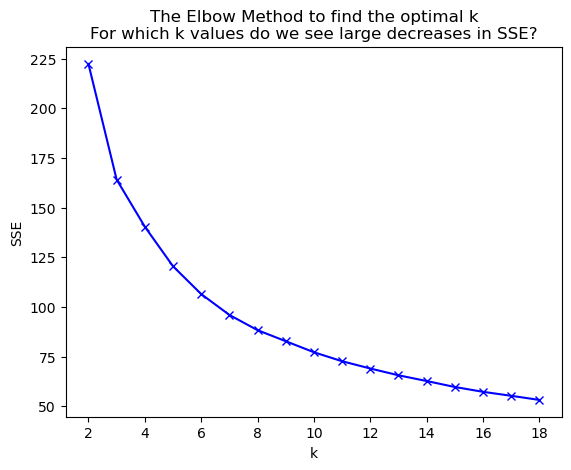

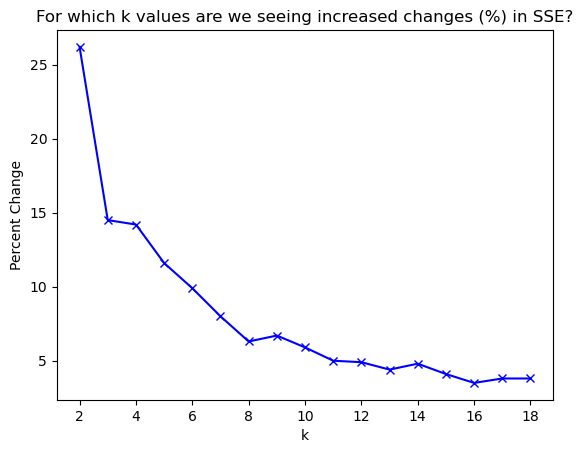

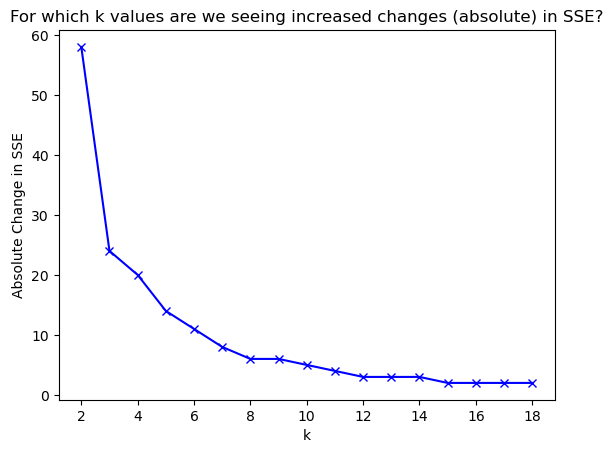

,k,sse,delta,pct_delta
0,2,222.300757,58.0,26.2
1,3,164.099001,24.0,14.5
2,4,140.367803,20.0,14.2
3,5,120.458963,14.0,11.6
4,6,106.458918,11.0,9.9
5,7,95.954790,8.0,8.0
6,8,88.284400,6.0,6.3
7,9,82.732294,6.0,6.7
8,10,77.166835,5.0,5.9
9,11,72.641557,4.0,5.0


In [258]:
find_k(X[0], cluster_vars, k_range)

In [259]:
k = 3

In [260]:
kmeans = create_clusters(X[0], k, cluster_vars)

In [261]:
centroid_df_acid = get_centroids(kmeans, cluster_vars, cluster_name)

In [262]:
X = assign_clusters(kmeans, cluster_vars, cluster_name, centroid_df_acid)

In [263]:
X[0]

,fixed,volatile,citric,sugar,chlorides,fso2,tso2,density,pH,alcohol,cluster,sulfur_dioxide,centroid_fso2,centroid_tso2,acids,centroid_fixed,centroid_volatile,centroid_citric
3498,0.346939,0.382609,0.571429,0.082840,0.447917,0.226667,0.538153,0.385195,0.698795,0.375000,3,1,0.252691,0.405567,0,0.366572,0.295114,0.458465
2089,0.653061,0.156522,0.500000,0.059172,0.458333,0.613333,0.574297,0.527073,0.590361,0.214286,3,1,0.252691,0.405567,0,0.366572,0.295114,0.458465
4934,0.632653,0.904348,0.178571,0.106509,0.802083,0.026667,0.032129,0.712132,0.746988,0.428571,2,1,0.252691,0.405567,0,0.366572,0.295114,0.458465
446,0.224490,0.347826,0.410714,0.118343,0.468750,0.386667,0.598394,0.294037,0.879518,0.714286,3,1,0.252691,0.405567,0,0.366572,0.295114,0.458465
3392,0.408163,0.521739,0.392857,0.529586,0.281250,0.453333,0.337349,0.328307,0.216867,0.714286,1,1,0.252691,0.405567,0,0.366572,0.295114,0.458465
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5055,0.489796,0.608696,0.678571,0.289941,0.645833,0.360000,0.485944,0.698424,0.746988,0.375000,2,0,0.477923,0.437216,1,0.505071,0.727635,0.302961
545,0.346939,0.139130,0.321429,0.047337,0.322917,0.533333,0.570281,0.424263,0.831325,0.285714,3,0,0.477923,0.437216,1,0.505071,0.727635,0.302961
3501,0.408163,0.278261,0.571429,0.461538,0.343750,0.546667,0.465863,0.522276,0.650602,0.446429,3,0,0.477923,0.437216,1,0.505071,0.727635,0.302961
4263,0.469388,0.817391,0.017857,0.437870,0.281250,0.240000,0.630522,0.382454,0.554217,0.678571,1,0,0.477923,0.437216,1,0.505071,0.727635,0.302961


In [264]:
cluster_vars = ['density', 'alcohol']
cluster_name = 'viscosity'
k_range = range(2,20)

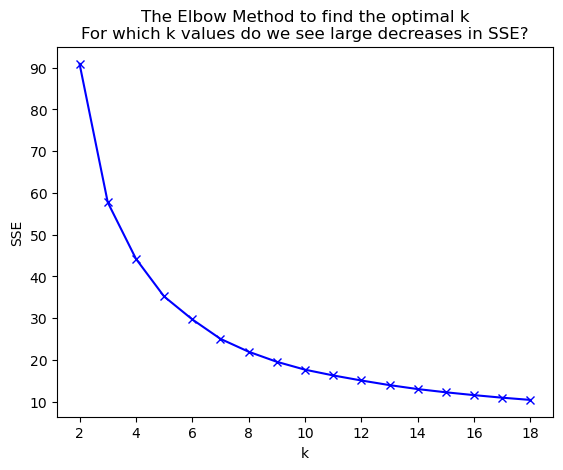

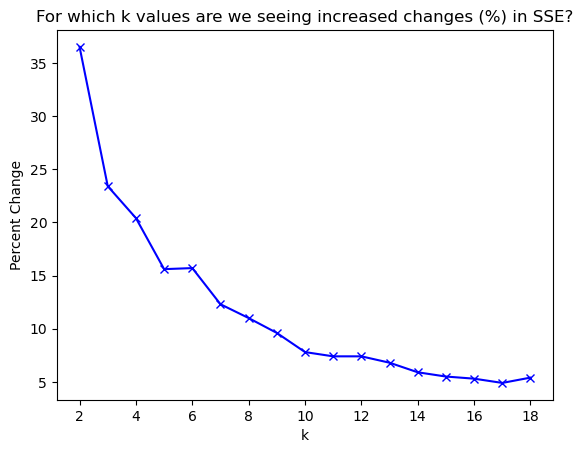

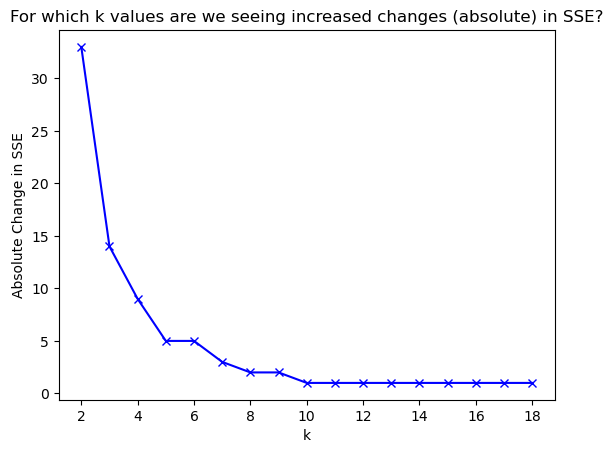

,k,sse,delta,pct_delta
0,2,90.887779,33.0,36.5
1,3,57.741303,14.0,23.4
2,4,44.227317,9.0,20.4
3,5,35.199622,5.0,15.6
4,6,29.710492,5.0,15.7
5,7,25.051461,3.0,12.3
6,8,21.971881,2.0,11.0
7,9,19.558902,2.0,9.6
8,10,17.674335,1.0,7.8
9,11,16.295616,1.0,7.4


In [265]:
find_k(X[0], cluster_vars, k_range)

In [266]:
k = 5

In [267]:
kmeans = create_clusters(X[0], k, cluster_vars)

In [268]:
centroid_df_visc = get_centroids(kmeans, cluster_vars, cluster_name)

In [269]:
X = assign_clusters(kmeans, cluster_vars, cluster_name, centroid_df_visc)

In [270]:
X[0]

,fixed,volatile,citric,sugar,chlorides,fso2,tso2,density,pH,alcohol,...,sulfur_dioxide,centroid_fso2,centroid_tso2,acids,centroid_fixed,centroid_volatile,centroid_citric,viscosity,centroid_density,centroid_alcohol
3498,0.346939,0.382609,0.571429,0.082840,0.447917,0.226667,0.538153,0.385195,0.698795,0.375000,...,1,0.252691,0.405567,0,0.366572,0.295114,0.458465,3,0.338700,0.467387
2089,0.653061,0.156522,0.500000,0.059172,0.458333,0.613333,0.574297,0.527073,0.590361,0.214286,...,1,0.252691,0.405567,0,0.366572,0.295114,0.458465,3,0.338700,0.467387
4934,0.632653,0.904348,0.178571,0.106509,0.802083,0.026667,0.032129,0.712132,0.746988,0.428571,...,1,0.252691,0.405567,0,0.366572,0.295114,0.458465,3,0.338700,0.467387
446,0.224490,0.347826,0.410714,0.118343,0.468750,0.386667,0.598394,0.294037,0.879518,0.714286,...,1,0.252691,0.405567,0,0.366572,0.295114,0.458465,3,0.338700,0.467387
3392,0.408163,0.521739,0.392857,0.529586,0.281250,0.453333,0.337349,0.328307,0.216867,0.714286,...,1,0.252691,0.405567,0,0.366572,0.295114,0.458465,3,0.338700,0.467387
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5055,0.489796,0.608696,0.678571,0.289941,0.645833,0.360000,0.485944,0.698424,0.746988,0.375000,...,0,0.477923,0.437216,1,0.505071,0.727635,0.302961,1,0.731077,0.164640
545,0.346939,0.139130,0.321429,0.047337,0.322917,0.533333,0.570281,0.424263,0.831325,0.285714,...,0,0.477923,0.437216,1,0.505071,0.727635,0.302961,1,0.731077,0.164640
3501,0.408163,0.278261,0.571429,0.461538,0.343750,0.546667,0.465863,0.522276,0.650602,0.446429,...,0,0.477923,0.437216,1,0.505071,0.727635,0.302961,1,0.731077,0.164640
4263,0.469388,0.817391,0.017857,0.437870,0.281250,0.240000,0.630522,0.382454,0.554217,0.678571,...,0,0.477923,0.437216,1,0.505071,0.727635,0.302961,1,0.731077,0.164640


In [277]:
X[2].drop(columns=['centroid_fso2', 'centroid_tso2','centroid_fixed',
                   'centroid_volatile','centroid_citric','centroid_density','centroid_alcohol'], inplace=True)

In [280]:
X[0]

,fixed,volatile,citric,sugar,chlorides,fso2,tso2,density,pH,alcohol,sulfur_dioxide,acids,viscosity
3498,0.346939,0.382609,0.571429,0.082840,0.447917,0.226667,0.538153,0.385195,0.698795,0.375000,1,0,3
2089,0.653061,0.156522,0.500000,0.059172,0.458333,0.613333,0.574297,0.527073,0.590361,0.214286,1,0,3
4934,0.632653,0.904348,0.178571,0.106509,0.802083,0.026667,0.032129,0.712132,0.746988,0.428571,1,0,3
446,0.224490,0.347826,0.410714,0.118343,0.468750,0.386667,0.598394,0.294037,0.879518,0.714286,1,0,3
3392,0.408163,0.521739,0.392857,0.529586,0.281250,0.453333,0.337349,0.328307,0.216867,0.714286,1,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5055,0.489796,0.608696,0.678571,0.289941,0.645833,0.360000,0.485944,0.698424,0.746988,0.375000,0,1,1
545,0.346939,0.139130,0.321429,0.047337,0.322917,0.533333,0.570281,0.424263,0.831325,0.285714,0,1,1
3501,0.408163,0.278261,0.571429,0.461538,0.343750,0.546667,0.465863,0.522276,0.650602,0.446429,0,1,1
4263,0.469388,0.817391,0.017857,0.437870,0.281250,0.240000,0.630522,0.382454,0.554217,0.678571,0,1,1


<AxesSubplot:xlabel='density', ylabel='alcohol'>

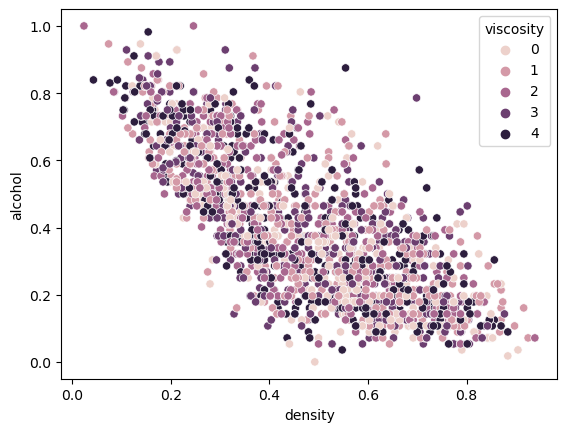

In [293]:
sns.scatterplot(x='density',y='alcohol',data=X[0].sample(2000), hue='viscosity')

In [299]:
def cluster_so2(L):
    
    cluster_vars = ['fso2', 'tso2']
    cluster_name = 'so2'
    
    k = 5
    
    kmeans = create_clusters(L[0], k, cluster_vars)
    
    centroid_df_so2 = get_centroids(kmeans, cluster_vars, cluster_name)
    
    L = assign_clusters(kmeans, cluster_vars, cluster_name, centroid_df_so2)
    
    return L

In [300]:
def cluster_acids(L):
    
    cluster_vars = ['fixed', 'volatile', 'citric']
    cluster_name = 'acids'
    
    k = 3
    
    kmeans = create_clusters(L[0], k, cluster_vars)
    
    centroid_df_acid = get_centroids(kmeans, cluster_vars, cluster_name)
    
    L = assign_clusters(kmeans, cluster_vars, cluster_name, centroid_df_acid)
    
    return L

In [302]:
def cluster_visc(L):
    
    cluster_vars = ['density', 'alcohol']
    cluster_name = 'visc'
    
    k = 5 
    
    kmeans = create_clusters(L[0], k, cluster_vars)
    
    centroid_df_visc = get_centroids(kmeans, cluster_vars, cluster_name)
    
    L = assign_clusters(kmeans, cluster_vars, cluster_name, centroid_df_visc)
    
    return L